# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируеум возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищем месторождения, для каждого определяем значения признаков;
- Строим модель и оцениваем объёмы запасов;
- Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
geo_data_0.csv. 
geo_data_1.csv. 
geo_data_2.csv. 
id — уникальный идентификатор скважины;
f0, f1, f2 — три признака скважины;
product — объём запасов в скважине (тыс. баррелей).

# Условия задачи

Для обучения модели подходит только линейная регрессия (остальные модели недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
import matplotlib.pyplot as plt

In [2]:
state = np.random.RandomState(12345)

data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

display(data_0.info())
display(data_1.info())
display(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Данные не требуют предобработки.

### Разобъем данные на обучающую и валидационную выборки в соотношении 75:25

In [3]:
features_0 = data_0.drop(columns=['product','id'], axis =1)
features_1 = data_1.drop(columns=['product','id'], axis =1)
features_2 = data_2.drop(columns=['product','id'], axis =1)
target_0 = data_0['product']
target_1 = data_1['product']
target_2 = data_2['product']
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
        features_0, target_0, test_size=0.25, random_state=12345)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
        features_1, target_1, test_size=0.25, random_state=12345)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
        features_2, target_2, test_size=0.25, random_state=12345)

target_valid_0=target_valid_0.reset_index(drop=True)
target_valid_1=target_valid_1.reset_index(drop=True)
target_valid_2=target_valid_2.reset_index(drop=True)

print(features_train_0.shape, target_train_0.shape)
print(features_train_1.shape, target_train_1.shape)
print(features_train_2.shape, target_train_2.shape)

print(features_valid_0.shape, target_valid_0.shape)
print(features_valid_1.shape, target_valid_1.shape)
print(features_valid_2.shape, target_valid_2.shape)

(75000, 3) (75000,)
(75000, 3) (75000,)
(75000, 3) (75000,)
(25000, 3) (25000,)
(25000, 3) (25000,)
(25000, 3) (25000,)


## Обучение и проверка модели

### Создадим функцию для обучения модели, предсказания объемов запасов, расчета средних запасов и расчета среднеквадратической ошибки предсказаний

In [4]:
def prediction (df, features_train,features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    avg_product = predictions.mean()
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse**0.5
    return model, 'avg_product:', avg_product, 'rmse:', rmse, 'predictions:', predictions

### Расчет предсказаний,  средних запасов и расчета среднеквадратической ошибки предсказаний.

In [5]:
model_0_results =prediction(data_0, features_train_0,features_valid_0, target_train_0, target_valid_0)
model_1_results =prediction(data_1, features_train_1,features_valid_1, target_train_1, target_valid_1)
model_2_results =prediction(data_2, features_train_2,features_valid_2, target_train_2, target_valid_2)
print(model_0_results[1:5])
print(model_1_results[1:5])
print(model_2_results[1:5])

('avg_product:', 92.59256778438035, 'rmse:', 37.5794217150813)
('avg_product:', 68.728546895446, 'rmse:', 0.893099286775617)
('avg_product:', 94.96504596800489, 'rmse:', 40.02970873393434)


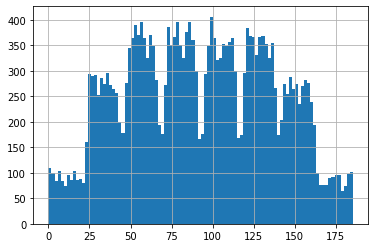

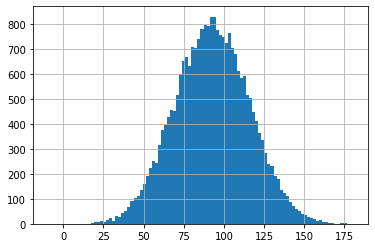

count    25000.000000
mean        92.078597
std         44.286913
min          0.004022
25%         56.059494
50%         90.897664
75%        128.160698
max        185.315412
Name: product, dtype: float64

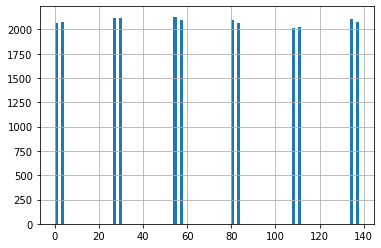

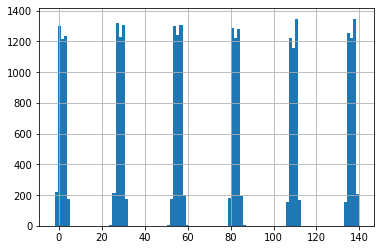

count    25000.000000
mean        68.723136
std         46.022165
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

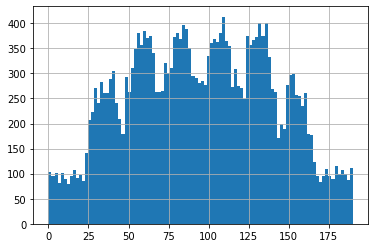

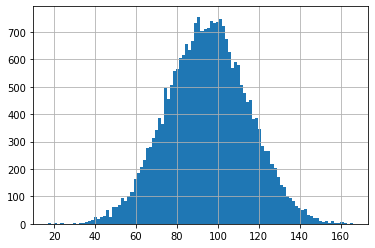

count    25000.000000
mean        94.884233
std         44.902982
min          0.000000
25%         59.217876
50%         94.979468
75%        130.568416
max        190.010982
Name: product, dtype: float64

In [6]:
target_valid_0.hist(bins=100)
plt.show()
model_0_results[6].hist(bins=100)
plt.show()
display (target_valid_0.describe())

target_valid_1.hist(bins=100)
plt.show()
model_1_results[6].hist(bins=100)
plt.show()
display (target_valid_1.describe())

target_valid_2.hist(bins=100)
plt.show()
model_2_results[6].hist(bins=100)
plt.show()
display (target_valid_2.describe())

Предсказания в 1 и 3 регионах имеют нормальное распределение. Во 2-м регионе - дискретное 

## Подготовка к расчёту прибыли

### Создадим функцию для расчета прибыли

In [7]:
def profit(subsample, target_valid, PROFIT_PER_MBOE, BUDGET):
    top_200 = subsample.sort_values(ascending =False)[:200]
    top_200_profit =target_valid[top_200.index].sum()*PROFIT_PER_MBOE-BUDGET
    return top_200_profit 

### Расчет объёма сырья для безубыточной разработки новой скважины.

In [8]:
PROFIT_PER_MBOE = 450000 #доход от тыс. барр.
BUDGET = 10**10 # расходы на 200 скважин
break_even_per_rig=BUDGET/200/PROFIT_PER_MBOE
break_even_per_rig

111.11111111111111

### Вывод
Чтобы покрыть инвестиции на одну скважину в среднем скважина должна дать более 111,1 тыс. барр, что выше среднего запаса на скважину в любом из регионов. Разрыв между средними запасами и точкой безубыточности для 1 и 3 региона не более 20 тыс. барр. Большой разрыв у 2 региона. Поэтому 2 регион наименее привлекательный.

## Расчёт прибыли и рисков 

### Создание функции для расчёта прибыли и рисков

In [9]:
def bootstrap_top_200 (predictions, target_valid):
    profit_list=[]
    for i in range(1000):
        subsample = predictions.sample(n=500, replace=True, random_state=state)
        subsample_profit = profit(subsample,target_valid, PROFIT_PER_MBOE, BUDGET)
        profit_list.append(subsample_profit)
    profit_list = pd.Series(profit_list)
    lower = profit_list.quantile(0.025)
    upper = profit_list.quantile(0.975)
    loss_prob = (profit_list < 0).mean()
    return "Прибыль:", profit_list.mean(), "95%-й доверительный интервал:",'lower:', lower, 'upper:', upper, "Вероятность убытков:",loss_prob 

### Расчет прибыли и рисков для регионов

In [10]:
region_0 = bootstrap_top_200(model_0_results[6],target_valid_0)
print (region_0)
region_1 = bootstrap_top_200(model_1_results[6],target_valid_1)
print (region_1)
region_2 = bootstrap_top_200(model_2_results[6],target_valid_2)
print (region_2)

('Прибыль:', 396164984.8023711, '95%-й доверительный интервал:', 'lower:', -111215545.89049526, 'upper:', 909766941.5534226, 'Вероятность убытков:', 0.069)
('Прибыль:', 461155817.2772397, '95%-й доверительный интервал:', 'lower:', 78050810.7517417, 'upper:', 862952060.2637234, 'Вероятность убытков:', 0.007)
('Прибыль:', 392950475.17060447, '95%-й доверительный интервал:', 'lower:', -112227625.37857565, 'upper:', 934562914.5511636, 'Вероятность убытков:', 0.065)


### Вывод 
Вероятность убытков везде около 7%. Однако второй регион единственный, у которого нижняя граница 95%-го доверительного интервала в положительной зоне. Поэтому рекомендация разрабатывать месторождение во 2-м регионе. 